In [1]:
import numpy as np
import tcbench as tcb
import faiss
import matplotlib.pyplot as plt

In [4]:
vectors_baseline = np.load('artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('artifacts-mirage19/baseline_labels.npy')

vectors_embeddings = np.load('artifacts-mirage19/embeddings_vectors_10d.npy')
labels_embeddings = np.load('artifacts-mirage19/embeddings_labels.npy')

In [5]:
vectors_embeddings[:2]

array([[ 0.07266331, -0.38888097, -0.63233334,  0.49369594,  0.6126003 ,
        -0.44663054,  1.3775549 , -0.21471761, -0.90646416,  1.3331381 ],
       [-0.7485144 , -0.51198703, -0.5954312 , -0.88661623,  0.23875351,
        -0.2438614 ,  0.17789093,  0.11349759, -0.31799683, -0.54114187]],
      dtype=float32)

In [6]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [25]:
def build_faiss_index(data, labels, train_indices, distance_type, samples_per_class = None):
    np.random.seed(42)

    filtered_data = data[train_indices]
    filtered_labels = labels[train_indices]
    d = filtered_data.shape[1]

    selected_data = []
    selected_indices = []
    unique_labels = np.unique(filtered_labels)
    for label in unique_labels:
        label_indices = np.where(filtered_labels == label)[0]
        if samples_per_class is None or samples_per_class == -1:
            selected_label_indices = label_indices
        else:
            selected_label_indices = np.random.choice(label_indices, size=min(samples_per_class, len(label_indices)), replace=False)
        selected_data.append(filtered_data[selected_label_indices])
        selected_indices.extend(train_indices[selected_label_indices])
    selected_data = np.vstack(selected_data)
    selected_indices = np.array(selected_indices)

    if distance_type == 'euclidean':
        index = faiss.IndexFlatL2(d)
    elif distance_type == 'cosine':
        selected_data = selected_data / np.linalg.norm(selected_data, axis=1, keepdims=True)
        index = faiss.IndexFlatIP(d)
    else:
        raise ValueError("Unsupported distance type. Use 'euclidean' or 'cosine'.")

    index.add(selected_data)
    return index, selected_indices

In [37]:
def search_and_compare_labels(data, labels, test_indices, selected_indices, index, metric, limit=None):
    k = 1
    if metric == "distance":
        D, I = index.search(data[test_indices], k)
    elif metric == "similarity":
        query_vectors = data[test_indices]
        query_vectors = query_vectors / np.linalg.norm(query_vectors, axis=1, keepdims=True)
        D, I = index.search(query_vectors, k)
    
    test_labels = labels[test_indices]
    neighbor_labels = labels[selected_indices[I.flatten()]].reshape(I.shape)
    
    matches = 0
    classified = 0
    min_distances = []

    for i in range(len(test_labels)):  
        if metric == "distance":
            min_distances.append(np.sqrt(D[i,0]))
            if limit is not None and np.sqrt(D[i, 0]) > limit:
                continue
        if metric == "similarity":
            min_distances.append(D[i,0])
            if limit is not None and D[i, 0] < limit:
                continue
        classified += 1
        matches += test_labels[i] in neighbor_labels[i, :1]

    classified_percentage = (classified / len(test_labels)) * 100
    match_percentage = (matches / classified) * 100 if classified > 0 else 0
    return classified_percentage, match_percentage, min_distances

In [38]:
test_index, test_selected_indices = build_faiss_index(vectors_baseline[:2], labels_baseline[:2], np.array([0]), 'euclidean', None)
test_classified_percentage, test_match_percentage, test_min_distances = search_and_compare_labels(vectors_baseline[:2], labels_baseline[:2], np.array([1]), test_selected_indices, test_index, "distance", None)
test_min_distances

[1.0193273]

In [39]:
test_index, test_selected_indices = build_faiss_index(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'euclidean', None)
test_classified_percentage, test_match_percentage, test_min_distances = search_and_compare_labels(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices, test_index, "distance", None)
test_min_distances

[2.8606164]

In [40]:
test_index, test_selected_indices = build_faiss_index(vectors_embeddings[:2], labels_embeddings[:2], np.array([0]), 'cosine', None)
test_classified_percentage, test_match_percentage, test_min_distances = search_and_compare_labels(vectors_embeddings[:2], labels_embeddings[:2], np.array([1]), test_selected_indices, test_index, "similarity", None)
test_min_distances

[0.032693926]

In [41]:
def extract_results(vectors, labels, train_indices, test_indices, distance_type, metric, samples, limits):
    classified_results = {li: [] for li in limits}
    accuracy_results = {li: [] for li in limits}

    for limit in limits:
        for sample_size in samples:
            index, selected_indices = build_faiss_index(
                vectors, labels, train_indices, distance_type, sample_size
            )
            classified, accuracy, min_distances = search_and_compare_labels(
                vectors, labels, test_indices, selected_indices, index, metric, limit
            )
            classified_results[limit].append(classified)
            accuracy_results[limit].append(accuracy)   
    return classified_results, accuracy_results, min_distances

In [42]:
def plot_results(classified_results, accuracy_results, samples, distances):
    num_distances = len(distances)
    fig, axes = plt.subplots((num_distances + 1) // 2, 2, figsize=(12, 4 * ((num_distances + 1) // 2)), sharex=True)

    axes = axes.flatten()

    for i, distance in enumerate(distances):
        ax = axes[i]
        
        ax.plot(samples, accuracy_results[distance], label='Accuracy', color='blue')
        ax.set_xlabel('Number of Samples Per Class') 
        ax.set_ylabel('Accuracy (%)', color='blue')   
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_ylim(0, 100)
        ax.set_title(f'Distance: {distance}')
        ax.grid(True)
        
        ax2 = ax.twinx()
        ax2.plot(samples, classified_results[distance], label='Classified %', color='green', linestyle='--')
        ax2.set_xlabel('Number of Samples Per Class')
        ax2.set_ylabel('Classified Percentage (%)', color='green')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', labelcolor='green')
        
        # # Add legends
        # ax.legend(loc='upper left')
        # ax2.legend(loc='upper right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

In [43]:
samples = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,
            500,600,700,800,900,1000,2000,3000,4000,5000]

distances_baseline = [0.005, 0.01, 0.05, 0.1]
distances_embeddings = [0.1, 0.5, 1, 5]
similarities = [0.9, 0.95, 0.99, 0.995]

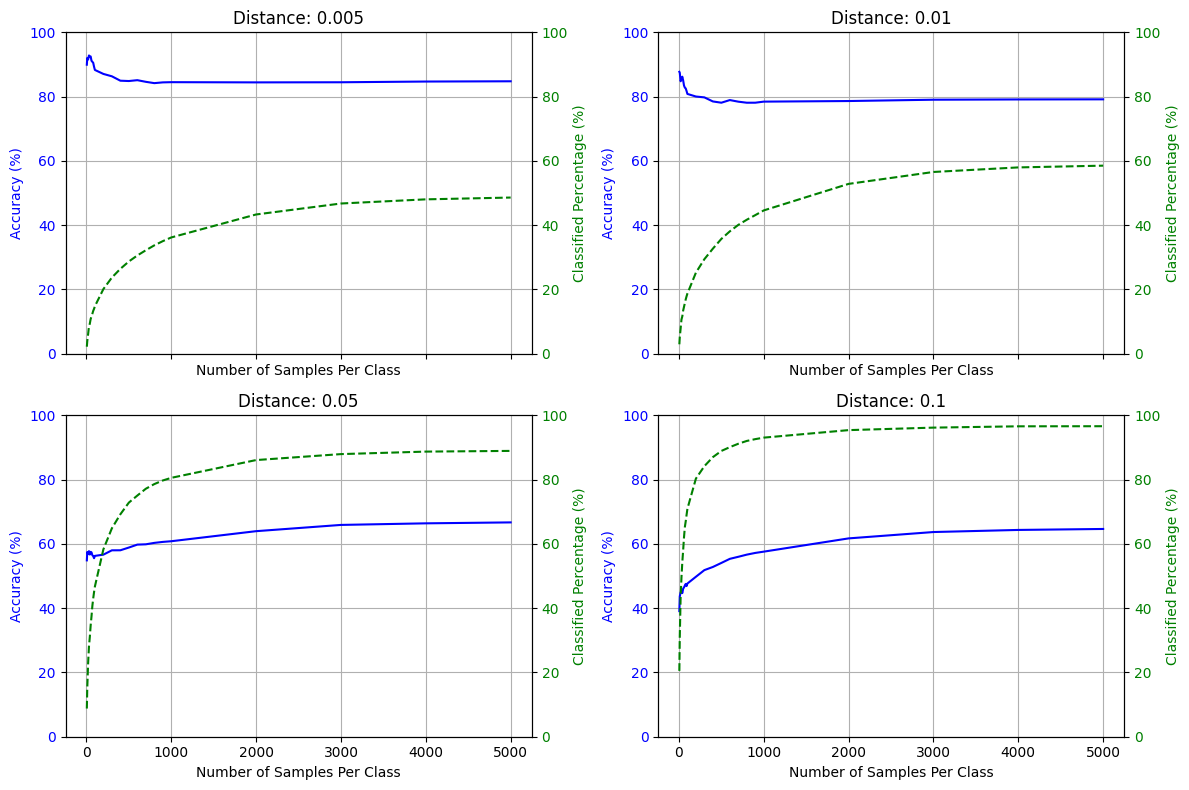

In [44]:
classified_results_baseline, accuracy_results_baseline, min_distances_baseline = extract_results(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_baseline)
plot_results(classified_results_baseline, accuracy_results_baseline, samples, distances_baseline)

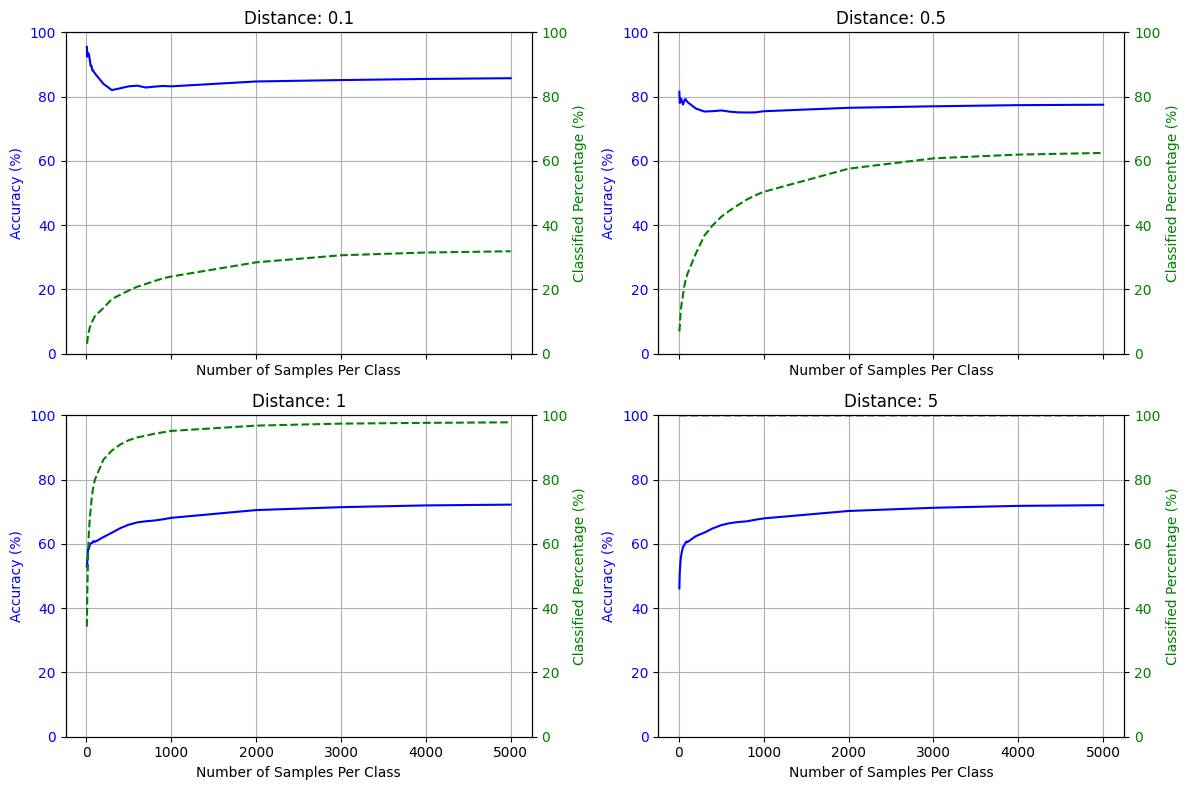

In [45]:
classified_results_embeddings, accuracy_results_embeddings, min_distances_embeddings = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, distances_embeddings)
plot_results(classified_results_embeddings, accuracy_results_embeddings, samples, distances_embeddings)

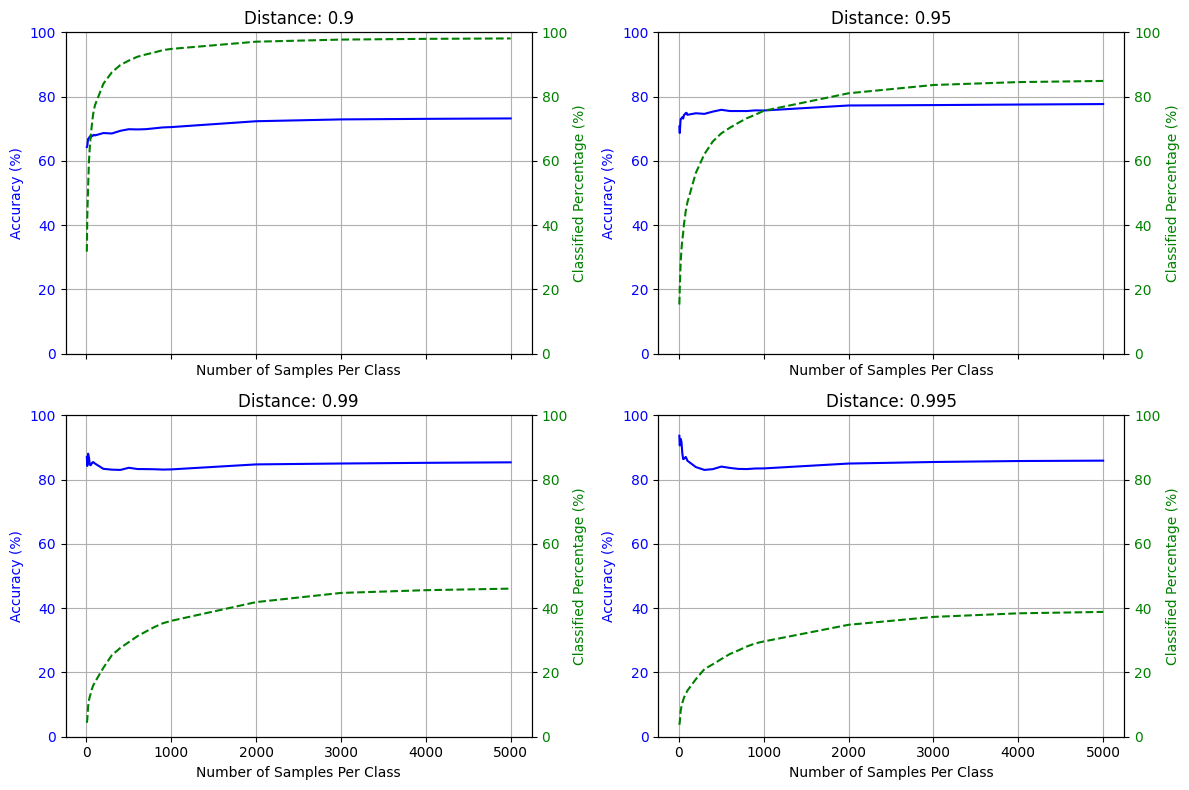

In [46]:
classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, min_distances_embeddings_cosine = extract_results(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, similarities)
plot_results(classified_results_embeddings_cosine, accuracy_results_embeddings_cosine, samples, similarities)

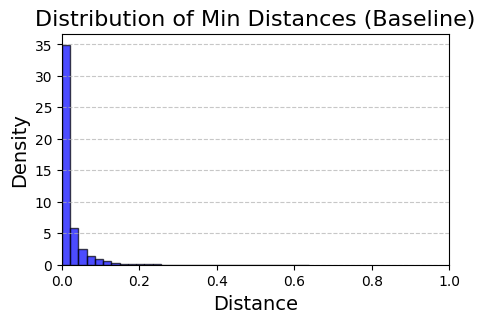

In [47]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_baseline, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Baseline)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

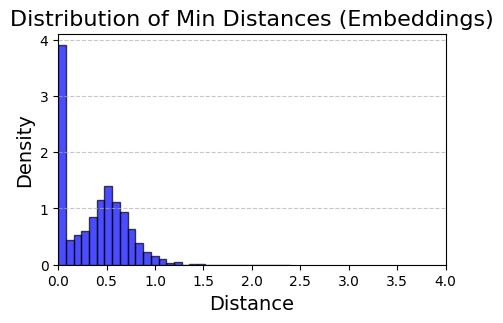

In [48]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_embeddings, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

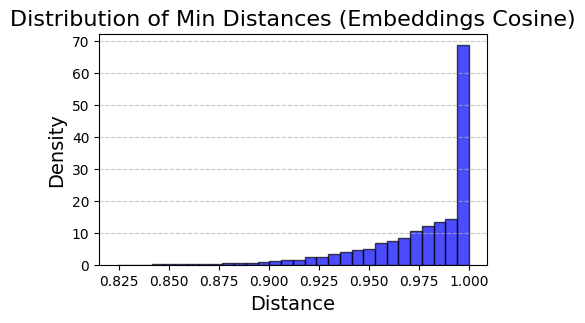

In [49]:
plt.figure(figsize=(5, 3))
plt.hist(min_distances_embeddings_cosine, bins=30, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title("Distribution of Min Distances (Embeddings Cosine)", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()